In [1]:
import scipy.io as sp_io
import scipy.integrate as sp_int
import importlib
import torus
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

KeyError: 'XUVTOP'

In [2]:
#constants 

c = 2.9979e10
mp = 1.67e-24
k_b = 1.3807e-16
m_e = 9.11e-28
e = 4.803e-10
G = 6.67e-8

In [3]:
##turn .sav file of solar spectrum into usable python solar spectrum 
"""** Structure <20abc08>, 6 tags, length=165722064, data length=165722064, refs=1:
   WAVELENGTH      FLOAT     Array[920]			(nm)
   DATE_YD         DOUBLE    Array[14989]		(YYYYDOY date format)
   DATE_JD         DOUBLE    Array[14989]		(Julian Day format)
   IRRADIANCE      FLOAT     Array[14989, 920]	(mW/m^2/nm)
   FLAG_SOURCE     FLOAT     Array[14989, 920]	(number from -1 to 139 that represents data source)
   MODEL           FLOAT     Array[14989, 920]	(mW/m^2/nm)
   UNCERTAINTY_IRRADIANCE   FLOAT     Array[920]    (unitless, % relative accuracy)
   UNCERTAINTY_MODEL        FLOAT     Array[920]    (unitless, % relative accuracy)"""



ss_idl = sp_io.readsav('ssi3_ext_0nm_1600nm.sav')
ss_wav = ss_idl['ssi3_ext'][0][0] #nm
ss_irr = ss_idl['ssi3_ext'][0][3][:, 1000] #mw/m^2/nm
ss_mod = ss_idl['ssi3_ext'][0][5][:, 1000] #mw/m^2/nm

#turn into cgs
ss_wav_cgs = ss_wav * 1e-7
ss_irr_cgs = ss_irr * 1e7
ss_nu_cgs = c / ss_wav_cgs
ss_irr_nu_cgs = ss_irr_cgs * ss_wav_cgs**2 / c

ss = {'wl' : ss_wav_cgs, 'F_wl' : ss_irr_cgs, 'nu' : ss_nu_cgs, 'F_nu' : ss_irr_nu_cgs}

def normalize_spectrum(stellar_spectrum, Feuv, euv_range = [1e-6, 1.17e-5]):

    normalized_stellar_spectrum = deepcopy(stellar_spectrum)
    euv_mask = (stellar_spectrum['wl'] > euv_range[0]) & (stellar_spectrum['wl'] < euv_range[1])
    Feuv_ss = sp_int.trapezoid(stellar_spectrum['F_wl'][euv_mask], stellar_spectrum['wl'][euv_mask])
    normalized_stellar_spectrum['F_wl'] *= (Feuv / Feuv_ss)
    normalized_stellar_spectrum['F_nu'] *= (Feuv / Feuv_ss)
    
    return normalized_stellar_spectrum

norm_ss = normalize_spectrum(ss, 10**4)

0.000284741836367175
(312, 400)


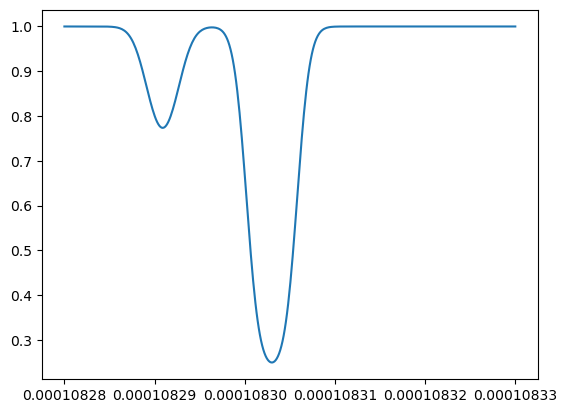

In [4]:
#Torus parameters 

#elements (in ratio compared to hydrogen)
#stellar spectrum in cgs
#stellar mass
#stellar radius 
#planet orbital semimajoraxis
#temperature of gas
#disc radius
#optical depth of gas to 13.6ev radiation


testTorus = torus.Torus({'h': 1, 'he' : 0.11}, norm_ss, 1e33, 7e10, 0.02*1.5e13, 10**4, 0.02*1.5e13, tau = 1)
#have a go at changing the he/hydrogen ratio to change
testTorus.calculate_ion_abundances_all_species()
wavgrid = np.linspace(1.0828e-4, 1.0833e-4, 400)
intensity = testTorus.do_transit_He()

plt.plot(wavgrid, intensity)

In [7]:
testTorus.nH / 1e9

0.01951392551156117

In [5]:
testTorus.calculate_tau_species('he_triplet')

2.140985045401814

In [33]:
def is_eclipse_visible(rm, rme):
    
    rse = 1.5e13
    #rme = 3.84e10
    rs = 6.9e10
    
    return rm * (rse - rme) / (rs * rme * (1 - rm / rs))

In [31]:
is_eclipse_visible(173.74e6, 3.84e10)

0.9835409842115495